# Determining the sparsity cutoff that produces the highest number of rejected hypotheses (alternative to DESeq2's independent filtering)

# Setting variables

In [2]:
workDir = '/home/chantal/Chazy/Chazy_SIP/data/'
figDir = '/home/chantal/Chazy/Chazy_SIP/data/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqSIP = 'SIP-core'


#biomFile = '/home/nick/notebook/fullCyc/data/MiSeq_16S/515f-806r/V4_Lib1-7/OTU_binning/otu_table_wtax.biom'
#metadataFile = '/home/nick/notebook/fullCyc/data/MiSeq_16S/515f-806r/V4_Lib1-7/metadata_SIP.txt'
#treeFile = '/home/nick/notebook/fullCyc/data/MiSeq_16S/515f-806r/V4_Lib1-6/fasttree/otusn.tree'


# l2fc params
l2fc_threshold = 1
BD_min = 1.7125    # from Ashley's succ-C paper; G+C =~ 0.54
BD_max = 2

# misc
nprocs = 10

# Init

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(DESeq2)
library(phyloseq)
library(grid); library(gridExtra)
library(plyr); library(dplyr)
library(tidyr)
library(ggplot2)
library(doParallel)
library(foreach)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: S4Vectors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: stats4

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: BiocGenerics

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘BiocGenerics’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/funct

In [5]:
%%R -i l2fc_threshold -i BD_min -i BD_max -i nprocs
cat('Params loaded in R\n')

Params loaded in R


In [6]:
%%R -i physeqDir -i physeqSIP

F = file.path(physeqDir, physeqSIP)
print(F)
physeq.SIP = readRDS(F)
physeq.SIP.m = physeq.SIP %>% sample_data
physeq.SIP = prune_samples(!(physeq.SIP.m$Full.sample %in% c('12C.PTH.D30.R3_Frac26','12C.NTH.D3.R4.Frac9')),
                           physeq.SIP) %>% filter_taxa(function(x) sum(x) > 0, TRUE)

physeq.SIP

[1] "/home/chantal/Chazy/data/phyloseq//SIP-core"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 21115 taxa and 608 samples ]
sample_data() Sample Data:       [ 608 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 21115 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 21115 tips and 21114 internal nodes ]


In [7]:
%%R
physeq.SIP.m$Substrate = physeq.SIP.m$Treatment
physeq.SIP = merge_phyloseq(physeq.SIP, physeq.SIP.m)
physeq.SIP

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 21115 taxa and 608 samples ]
sample_data() Sample Data:       [ 608 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 21115 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 21115 tips and 21114 internal nodes ]


In [103]:
%%R
unique(physeq.SIP.m$Replicate)

[1] 4


In [8]:
%%R
physeq.m = physeq.SIP %>% sample_data

In [ ]:
%%R
mdf = psmelt(physeq.SIP)

In [ ]:
%%R
head(mdf)

In [ ]:
%%R
mdf_sum = mdf %>% group_by(Full.sample, Gradient, Treatment, Till, Day, Land_Management) %>% 
          summarise(seqs = sum(Abundance))
mdf_sum$Full.sample <- factor(mdf_sum$Full.sample, levels = mdf_sum$Full.sample[order(mdf_sum$seqs)])
mdf_sum$Gradient <- factor(mdf_sum$Gradient, levels = mdf_sum$Gradient[order(mdf_sum$seqs)])

In [ ]:
%%R
head(mdf_sum)

In [ ]:
%%R
range(mdf_sum$seqs)

In [ ]:
%%R -h 600 -w 800
pl = ggplot(data = mdf_sum, aes(x = Gradient, y = seqs))
pl = pl + geom_bar(stat = 'identity', aes(fill = Full.sample), color = 'black') + theme(text = element_text(size=18),
        axis.title.y = element_text(vjust=1),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)) + guides(fill=FALSE)

#pl = pl + scale_fill_brewer()

pl

In [ ]:
%%R 
#-i biomFile -i treeFile -i metadataFile

# asNumeric = function(x) { as.numeric(as.character(x)) }

# physeq = import_biom(biomFile, treeFile)
# sample.data = import_qiime_sample_data(metadataFile)
# sample.data$Buoyant_density = asNumeric(sample.data$Buoyant_density)

# physeq = merge_phyloseq(physeq, sample.data)
# physeq

In [10]:
%%R
# check on number of gradients

n.gradient = physeq.SIP %>% sample_data %>% as.matrix %>% as.data.frame %>%
            distinct(Day, Substrate, Land_Management) %>% nrow
cat('Number of gradients:', n.gradient, '\n')

Number of gradients: 26 


In [11]:
%%R
     
asNumeric = function(x) { as.numeric(as.character(x)) }

get_Ps = function(physeq.obj, Substrate, Day, Replicate, Land_Management,
                  density.min, density.max, l2fc_threshold, sparsity_threshold) {
    # function for calculating log2 fold change p-values
    

    Substrate = c(Substrate %>% as.character)
    
    physeq.md = sample_data(physeq.obj)
    # filtering
    p.12C = prune_samples((physeq.md$Substrate == "12C") &
                          (physeq.md$Day == Day) &
                          (physeq.md$Replicate == Replicate) & 
                          (physeq.md$Land_Management == Land_Management) &
                          (physeq.md$Density >= density.min)&
                          (physeq.md$Density <= density.max), 
                           physeq.obj)

    p.13C = prune_samples((physeq.md$Substrate == Substrate) &
                      (physeq.md$Day == Day) &
                      (physeq.md$Replicate == Replicate) & 
                      (physeq.md$Land_Management == Land_Management) &
                      (physeq.md$Density >= density.min)&
                      (physeq.md$Density <= density.max), 
                      physeq.obj)

    physeq.m = merge_phyloseq(p.12C, p.13C)

    physeq.m = filter_taxa(physeq.m, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
  

    
    # deseq
    dds = phyloseq_to_deseq2(physeq.m, ~Substrate)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
    theta = l2fc_threshold
        
    # results
    res = results(dds, independentFiltering=FALSE)
    res$OTU = rownames(res)
        
    # p-value
    beta = res$log2FoldChange
    betaSE = res$lfcSE
    p = pnorm(beta, theta, betaSE, lower.tail=FALSE)
    res$p = p
    d = data.frame(res[, c("OTU","log2FoldChange", "p")])
    print(d)
    # p-value adjust
    d$padj = p.adjust(p, method = "BH")
        
    # taxonomy data
    TT = physeq.m %>% tax_table %>% data.frame
    TT$OTU = rownames(TT)
    d = left_join(d, TT, c('OTU'))
    d
}

In [ ]:
%%R -w 600 -h 250
#-- debug Ps debug --#
l2fc.res = get_Ps(physeq.SIP, 
                  Substrate='13C', 
                  Day=14, 
                  Replicate=4,
                  Land_Management = "PTH",
                  density.min=BD_min, 
                  density.max=BD_max,
                  l2fc_threshold=l2fc_threshold,
                  sparsity_threshold=0.05) 

l2fc.res %>% head(n=3) %>% print

ggplot(l2fc.res, aes(padj)) +
    geom_histogram(binwidth=0.01)

In [12]:
%%R
# list of substrate-day-microcosm rep combinations
## no 12C-con, because it is the comparison 

sdm = physeq.SIP %>% sample_data %>% 
    filter(! is.na(Density),
           Substrate != '12C') %>%
    select(Substrate, Day, Replicate, Land_Management) %>%
    distinct() %>%
    arrange(Substrate, Replicate, Day, Land_Management) 

sdm %>% nrow %>% print
sdm %>% head(n=5)
sdm

[1] 16
   Substrate Day Replicate Land_Management
1        13C   3         4             NTH
2        13C   3         4             PTH
3        13C   7         4             NTH
4        13C   7         4             PTH
5        13C  14         4             NTH
6        13C  14         4             PTH
7        13C  30         4             NTH
8        13C  30         4             PTH
9        13X   1         4             NTH
10       13X   1         4             PTH
11       13X   3         4             NTH
12       13X   3         4             PTH
13       13X   7         4             NTH
14       13X   7         4             PTH
15       13X  14         4             NTH
16       13X  14         4             PTH


In [13]:
%%R
# adding range of sparsity thresholds (all pairwise)
sdms = sdm %>%
    unite(sdm, Substrate, Day, Replicate, Land_Management, sep='___')

sdms = expand.grid(sdms$sdm,
                    sparsity_threshold = seq(0.05,0.95,0.05)) %>%
    separate(Var1, c('Substrate', 'Day', 'Replicate', 'Land_Management'), sep='___')


cat('Number of pairwise combinations of variables:', sdms %>% nrow, '\n\n')
sdms %>% head(7)

Number of pairwise combinations of variables: 304 

  Substrate Day Replicate Land_Management sparsity_threshold
1       13C   3         4             NTH               0.05
2       13C   3         4             PTH               0.05
3       13C   7         4             NTH               0.05
4       13C   7         4             PTH               0.05
5       13C  14         4             NTH               0.05
6       13C  14         4             PTH               0.05
7       13C  30         4             NTH               0.05


In [ ]:
%%R 
registerDoParallel(nprocs)

# debug
m = sdms %>% head(n=5)

df.l2fc = mdply(sdms,
                get_Ps, 
                .parallel = FALSE, 
                physeq.obj = physeq.SIP,
                density.min = BD_min,
                density.max = BD_max,
                l2fc_threshold = l2fc_threshold) %>% tbl_df

In [57]:
%%R

head(df.l2fc)

Source: local data frame [6 x 17]

  Substrate   Day Replicate Land_Management sparsity_threshold      OTU
      (chr) (chr)     (chr)           (chr)              (dbl)    (chr)
1       13C     3         4             NTH               0.05 OTU.4940
2       13C     3         4             NTH               0.05 OTU.4163
3       13C     3         4             NTH               0.05 OTU.5493
4       13C     3         4             NTH               0.05 OTU.1739
5       13C     3         4             NTH               0.05 OTU.1813
6       13C     3         4             NTH               0.05  OTU.778
Variables not shown: log2FoldChange (dbl), p (dbl), padj (dbl), Rank1 (fctr),
  Rank2 (fctr), Rank3 (fctr), Rank4 (fctr), Rank5 (fctr), Rank6 (fctr), Rank7
  (fctr), Rank8 (fctr)


In [ ]:
%%R -i workDir
# saving results

outFile = paste(c(workDir, 'l2fc_all_sparsity_df'), collapse='/')
saveRDS(df.l2fc, outFile)

## Summing number of rejected hypotheses

In [ ]:
%%R -i workDir
# reading in results
inFile = paste(c(workDir, 'l2fc_all_sparsity_df'), collapse='/')
df.l2fc = readRDS(inFile)

df.l2fc %>% head(n=3) %>% as.data.frame

In [104]:
%%R
unique(df.l2fc$Replicate)

[1] "4"


In [105]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH = df.l2fc %>%
    filter(padj < padj.cutoff) %>%
    group_by(sparsity_threshold, Substrate, Day, Replicate, Land_Management) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH %>% head(n=6)

Source: local data frame [6 x 6]

  sparsity_threshold Substrate   Day Replicate Land_Management n_reject_hypo
               (dbl)     (chr) (chr)     (chr)           (chr)         (int)
1               0.05       13C    14         4             NTH           202
2               0.05       13C    14         4             PTH            94
3               0.05       13C     3         4             NTH             1
4               0.05       13C     3         4             PTH            37
5               0.05       13C    30         4             NTH           265
6               0.05       13C    30         4             PTH           197


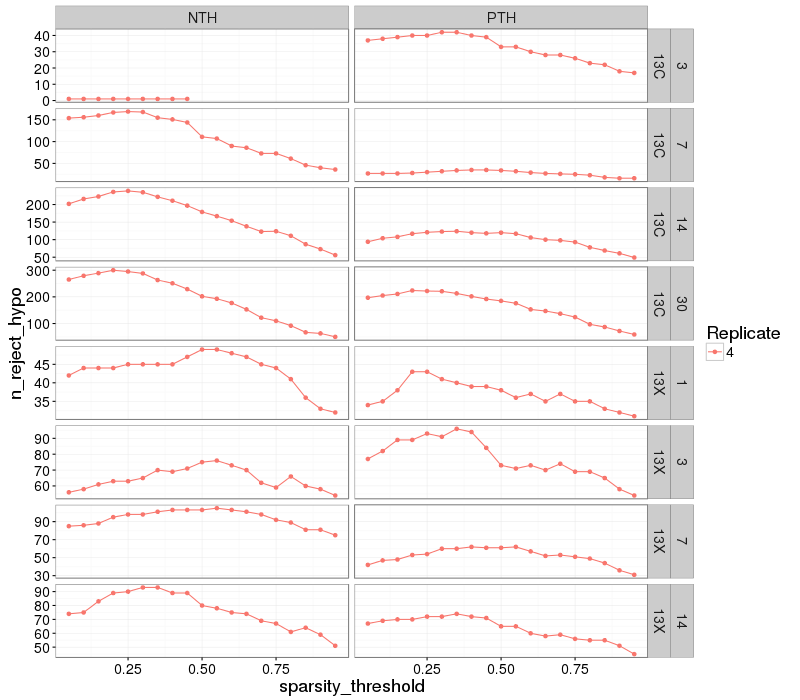

In [106]:
%%R -w 800 -h 700

df.l2fc.rejH$Day = reorder(df.l2fc.rejH$Day, df.l2fc.rejH$Day %>% as.numeric)

ggplot(df.l2fc.rejH, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(aes(color= Replicate)) +
    geom_line(aes(color = Replicate)) +
    facet_grid(Substrate ~ Day ~ Land_Management, scales = "free_y") +
    theme_bw() +
    theme(
        text = element_text(size=18)
        )

### Summarize the number of rejected hypotheses for all day-substrate treatments combined

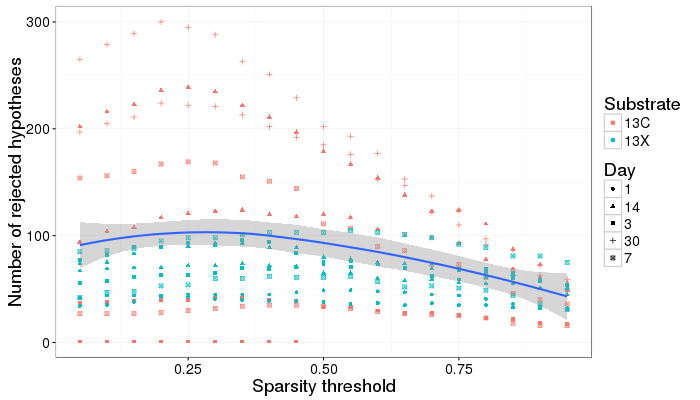

In [107]:
%%R -w 700 -h 400

df.l2fc.rejH = df.l2fc.rejH %>%
    mutate(Day = as.character(Day))

ggplot(df.l2fc.rejH, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(aes(color=Substrate, shape=Day)) +
    geom_smooth(method='loess') +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        )

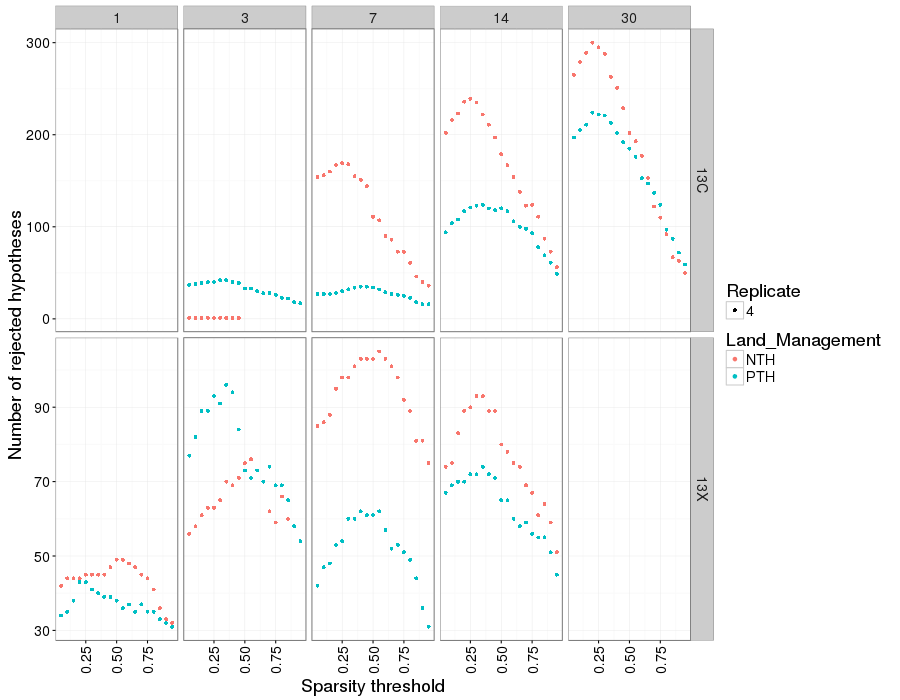

In [108]:
%%R -w 900 -h 700

df.l2fc.rejH = df.l2fc.rejH %>%
    mutate(Day = as.character(Day))

df.l2fc.rejH$Day = reorder(df.l2fc.rejH$Day, df.l2fc.rejH$Day %>% as.numeric)

ggplot(df.l2fc.rejH, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(aes(color=Land_Management, shape=Replicate)) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    facet_grid(Substrate ~ Day,scales = "free_y" ) +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

In [109]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH.s = df.l2fc %>%
    filter(padj <= padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH.s %>% head(n=3) %>% as.data.frame

  sparsity_threshold n_reject_hypo
1               0.05          1454
2               0.10          1522
3               0.15          1579


In [110]:
%%R
# max number of rejected hypos 
max.rejH = df.l2fc.rejH.s %>%
    arrange(desc(n_reject_hypo)) %>%
    head(n=1)
max.rejH = max.rejH$sparsity_threshold
max.rejH

[1] 0.25


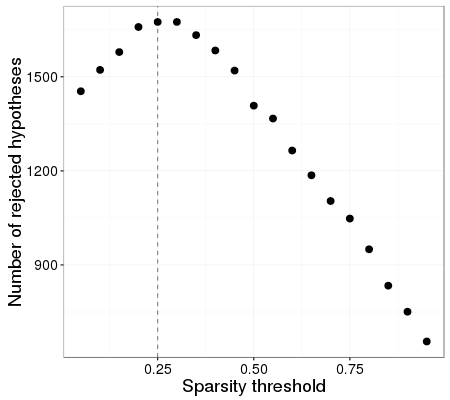

In [111]:
%%R -w 450 -h 400

ggplot(df.l2fc.rejH.s, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(size=3) +
    geom_vline(xintercept=max.rejH, linetype='dashed', alpha=0.5) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        )

# Selecting l2fc values for sparsity cutoff with max rejected hypotheses

In [112]:
%%R
df.l2fc.f = df.l2fc %>%
    filter(sparsity_threshold == max.rejH) %>%
    mutate(Day = as.numeric(Day))

df.l2fc.f %>% nrow

[1] 70388


In [113]:
%%R -i workDir
# Writing out l2fc table

outFile = paste(c(workDir, 'l2fc_sparse-maxRejH.txt'), collapse='/')
write.table(df.l2fc.f, outFile, sep='\t', quote=FALSE, row.names=FALSE)

## Plotting results

In [6]:
%%R
df.l2fc.f = read.table('data/l2fc_sparse-maxRejH.txt', header = TRUE, sep = '\t')
head(df.l2fc.f)

  Treatment Day Replicate Land_Management      OTU log2FoldChange         p
1       13C   3         4             NTH OTU.4163      0.2905525 0.4758928
2       13C   3         4             NTH OTU.5493     -0.2477539 0.8663980
3       13C   3         4             NTH OTU.1739     -0.3623365 0.9103254
4       13C   3         4             NTH OTU.1813      0.0000000 1.0000000
5       13C   3         4             NTH  OTU.778      0.4419146 0.3382425
6       13C   3         4             NTH OTU.5511      0.6736674 0.2322352
  padj    Rank1            Rank2          Rank3                  Rank4 Rank5
1    1 Bacteria    __Chloroflexi         __S085 __uncultured_bacterium  <NA>
2    1 Bacteria    __Chloroflexi         __S085 __uncultured_bacterium  <NA>
3    1 Bacteria __Planctomycetes        __OM190 __uncultured_bacterium  <NA>
4    1 Bacteria __Planctomycetes        __OM190 __uncultured_bacterium  <NA>
5    1 Bacteria __Planctomycetes __Pla4_lineage __uncultured_bacterium  <NA>
6    1

In [51]:
%%R
unique(df.l2fc.f$Replicate)
df.l2fc.f$Substrate = df.l2fc.f$Treatment

In [52]:
%%R
df.l2fc.f$ls = as.character(paste(df.l2fc.f$Treatment, df.l2fc.f$Land_Management, sep = "-"))
head(df.l2fc.f) %>% select(Treatment, Land_Management, ls)

  Treatment Land_Management      ls
1       13C             NTH 13C-NTH
2       13C             NTH 13C-NTH
3       13C             NTH 13C-NTH
4       13C             NTH 13C-NTH
5       13C             NTH 13C-NTH
6       13C             NTH 13C-NTH


In [53]:
%%R
df.l2fc.f %>% filter(padj <=0.10) %>% group_by(ls) %>% summarise(resp = length(unique(OTU)))

Source: local data frame [4 x 2]

       ls  resp
    (chr) (int)
1 13C-NTH  1062
2 13C-PTH   935
3 13X-NTH   582
4 13X-PTH   604


In [236]:
%%R
df.l2fc.f %>% filter(padj <=0.10) %>% group_by(ls, Day) %>% summarise(resp = length(unique(OTU)))

Source: local data frame [16 x 3]
Groups: ls [?]

        ls   Day  resp
     (chr) (int) (int)
1  13C-NTH     3    17
2  13C-NTH     7   345
3  13C-NTH    14   545
4  13C-NTH    30   728
5  13C-PTH     3   185
6  13C-PTH     7   128
7  13C-PTH    14   412
8  13C-PTH    30   623
9  13X-NTH     1   127
10 13X-NTH     3   295
11 13X-NTH     7   282
12 13X-NTH    14   356
13 13X-PTH     1   161
14 13X-PTH     3   293
15 13X-PTH     7   296
16 13X-PTH    14   303


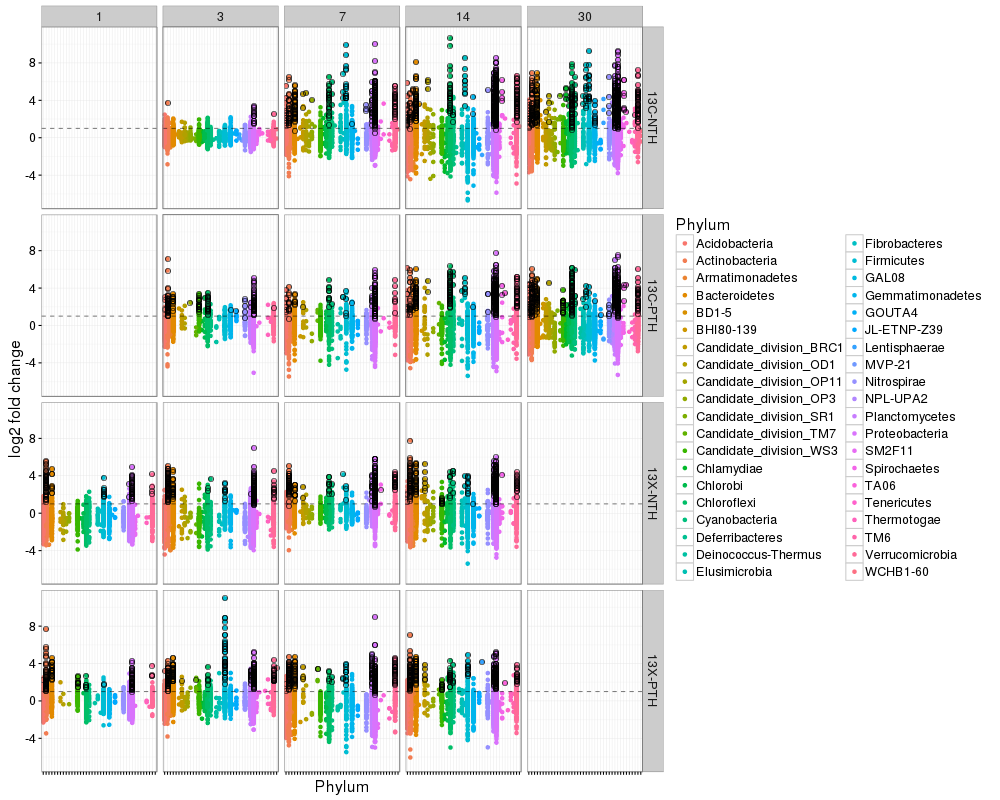

In [54]:
%%R -w 1000 -h 800
padj_cutoff = 0.10
l2fc_threshold = 1

df.l2fc.f = df.l2fc.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

df.l2fc.f.sig = df.l2fc.f %>%
    filter(padj <= padj_cutoff) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc = ggplot(df.l2fc.f, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    geom_point(data=df.l2fc.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(ls ~ Day) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
        )
p.l2fc

In [55]:
%%R -i figDir
outFile = 'l2fc_sparCut0.2_byPhylum.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.l2fc, width=12, height=9)

### Example figure

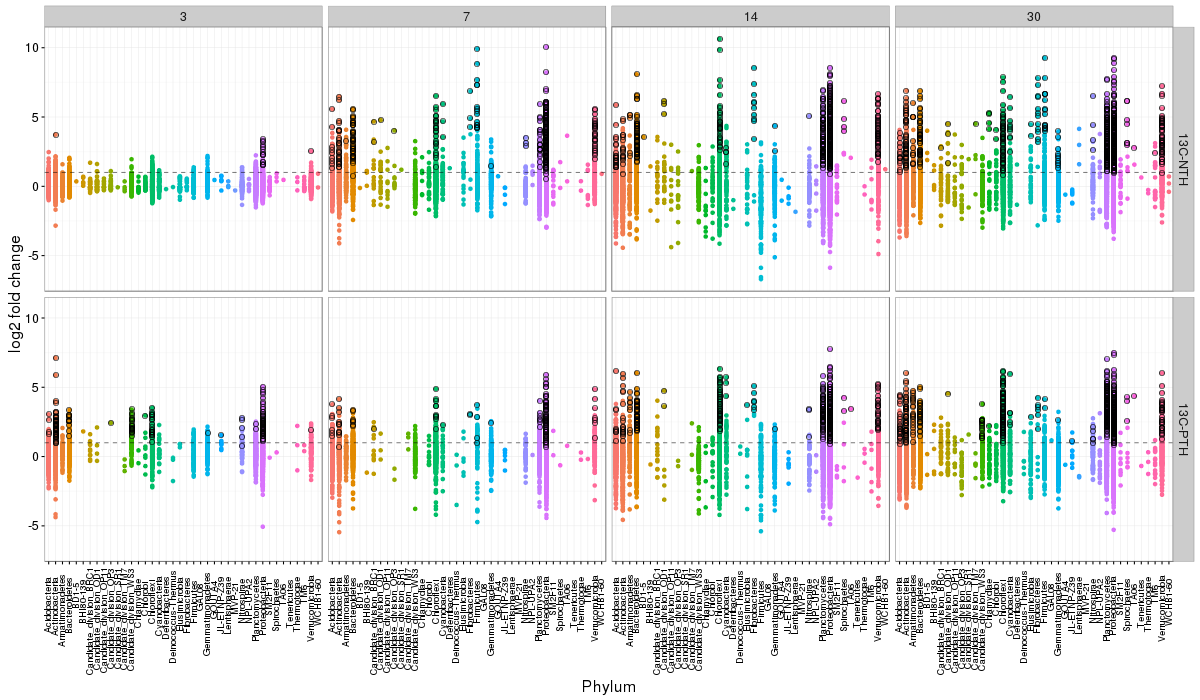

In [279]:
%%R -w 1200 -h 700
padj_cutoff = 0.10

df.l2fc.f.f = df.l2fc.f %>%
    filter(Substrate == '13C') %>%
    mutate(Rank2 = Rank2 %>% as.character)

df.l2fc.f.f = df.l2fc.f.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))
#df.l2fc.f.f$Phyl = reorder(df.l2fc.f.f$Rank2, -df.l2fc.f.f$log2FoldChange)


df.l2fc.f.f.sig = df.l2fc.f.f %>%
    filter(padj <= padj_cutoff) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))
#df.l2fc.f.f.sig$Phyl = reorder(df.l2fc.f.f.sig$Rank2, -df.l2fc.f.f.sig$log2FoldChange)

p.l2fc.x = ggplot(df.l2fc.f.f, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    geom_point(data=df.l2fc.f.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(ls~Day) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16), axis.text.x  = element_text(angle=90, vjust=0.4, hjust = 0.8, size=9)) +#,
        #axis.text.x = element_blank() 
         guides(color = FALSE)
p.l2fc.x

In [280]:
%%R -w 1500 -h 300

hist.cell = df.l2fc.f.f %>% group_by(Day, ls, Rank2) %>% summarise(respcounts = sum(padj <=0.10))
hist.cell[is.na(hist.cell)] <- 0

head(hist.cell)

Source: local data frame [6 x 4]
Groups: Day, ls [1]

    Day      ls           Rank2 respcounts
  (int)   (chr)           (chr)      (int)
1     3 13C-NTH   Acidobacteria          0
2     3 13C-NTH  Actinobacteria          1
3     3 13C-NTH Armatimonadetes          0
4     3 13C-NTH   Bacteroidetes          0
5     3 13C-NTH           BD1-5          0
6     3 13C-NTH       BHI80-139          0


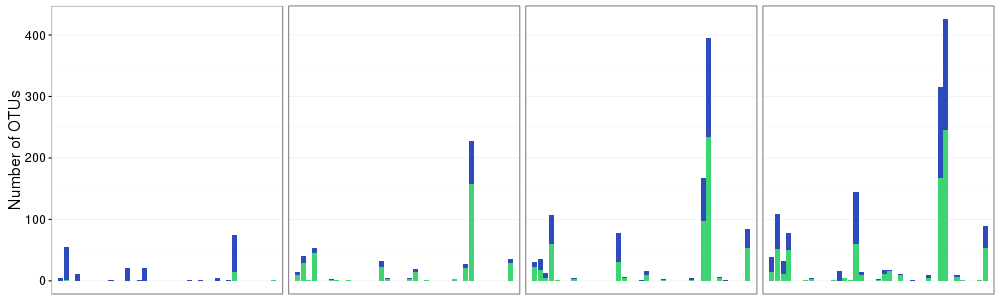

In [281]:
%%R -w 1000 -h 300
p.test = ggplot() + geom_bar(data = hist.cell, aes(x = Rank2, y = respcounts, fill = ls), stat = 'identity',
                             position = 'stack') +
    facet_grid(1~Day) + theme_bw() + scale_fill_manual(name = 'Condition', values = c("#3ed474",
"#2e4bbd")) + theme(text = element_text(size = 16), axis.title.x = element_blank()) +
        ylab('Number of OTUs') +  scale_x_discrete(breaks=NULL)+ guides(fill = FALSE) + 
 theme(strip.background = element_blank(),
       strip.text.x = element_blank(), strip.text.y = element_blank()) 
p.test

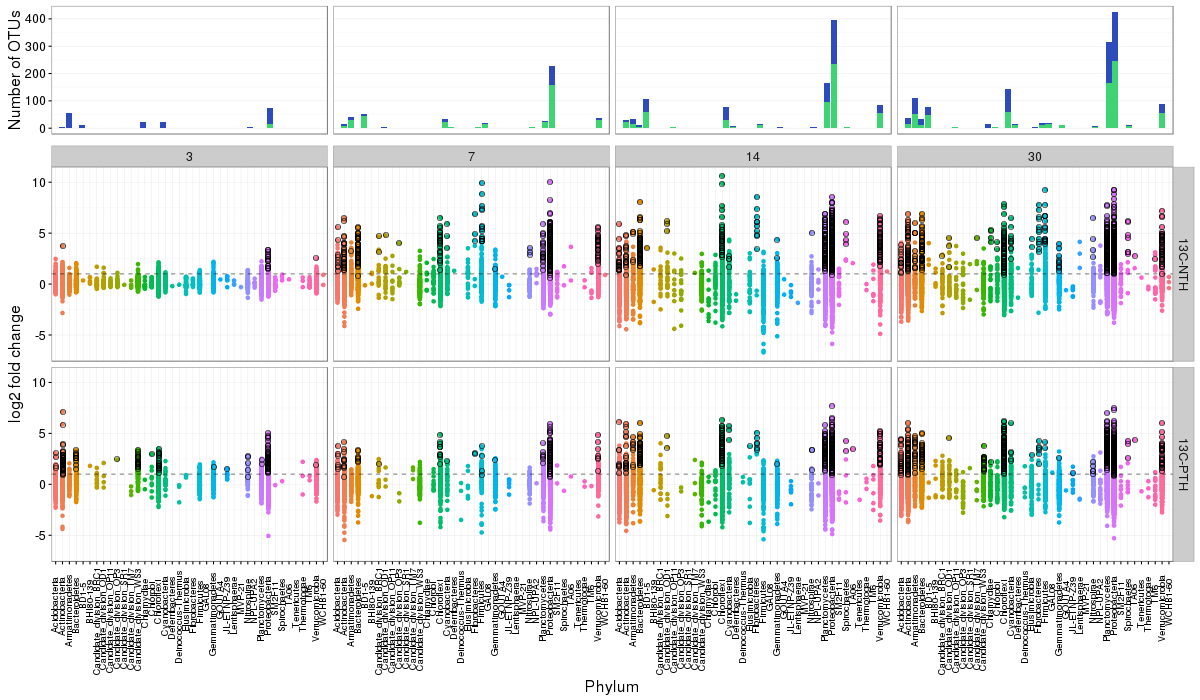

In [284]:
%%R -w 1200 -h 700
library(cowplot)

plot_grid(p.test, p.l2fc.x, nrow = 2, align = 'v', rel_heights = c(2.5, 10))


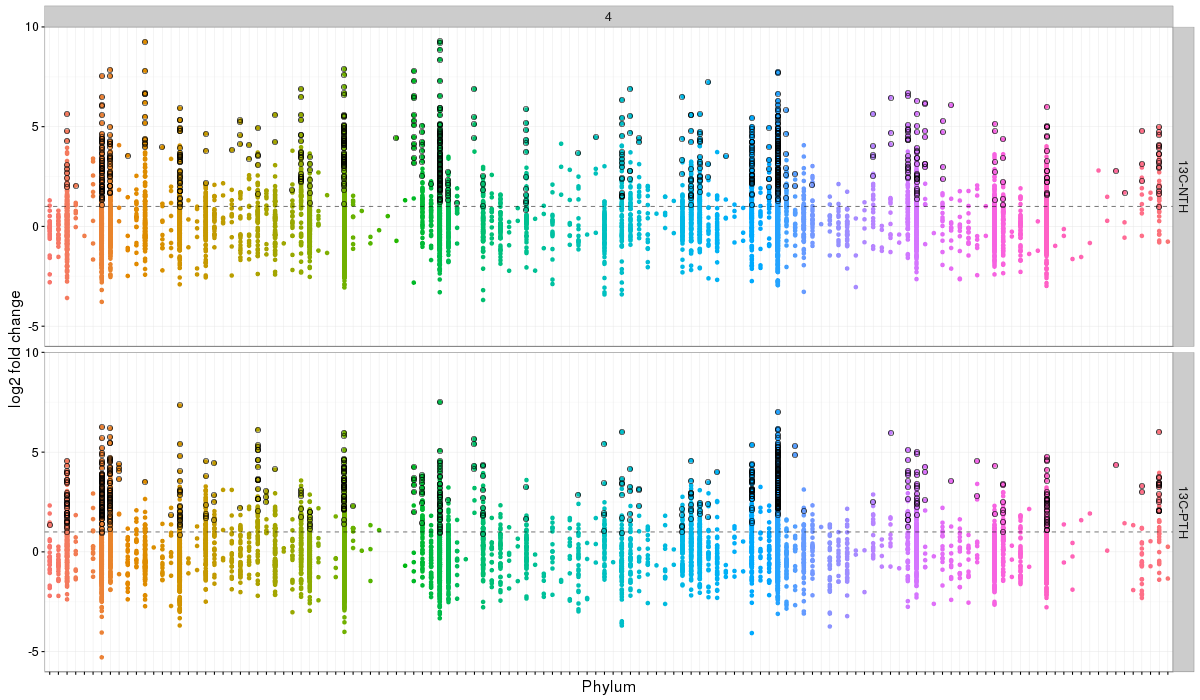

In [57]:
%%R -w 1200 -h 700
padj_cutoff = 0.10

df.l2fc.f.30 = df.l2fc.f %>%
    filter(Substrate == '13C', Day == 30) %>%
    mutate(Rank3 = Rank3 %>% as.character)

df.l2fc.f.30 = df.l2fc.f.30 %>%
    mutate(Rank3 = gsub('^__', '', Rank3))
#df.l2fc.f.f$Phyl = reorder(df.l2fc.f.f$Rank2, -df.l2fc.f.f$log2FoldChange)


df.l2fc.f.30.sig = df.l2fc.f.30 %>%
    filter(padj <= padj_cutoff) %>%
    mutate(Rank3 = gsub('^__', '', Rank3))
#df.l2fc.f.f.sig$Phyl = reorder(df.l2fc.f.f.sig$Rank2, -df.l2fc.f.f.sig$log2FoldChange)

p.l2fc.x = ggplot(df.l2fc.f.30, aes(Rank3, color=Rank3)) +
    geom_point(aes(y=log2FoldChange)) +
    geom_point(data=df.l2fc.f.30.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(ls~Replicate) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank() 
        )+ guides(fill = FALSE, color = FALSE)

    
p.l2fc.x

In [58]:
%%R
head(df.l2fc.f.f.sig)

  Treatment Day Replicate Land_Management       OTU log2FoldChange            p
1       13C   3         4             NTH OTU.15764       2.281535 3.298661e-07
2       13C   3         4             NTH  OTU.5864       3.728986 1.888321e-08
3       13C  30         4             NTH  OTU.1739       2.384770 8.922444e-07
4       13C  30         4             NTH  OTU.1783       2.260276 1.277929e-03
5       13C  30         4             NTH  OTU.2004       2.021088 3.686796e-03
6       13C  30         4             NTH OTU.13455       1.870800 9.253734e-04
          padj    Rank1          Rank2                 Rank3
1 0.0012008777 Bacteria Proteobacteria  __Betaproteobacteria
2 0.0001374887 Bacteria Actinobacteria __Streptosporangiales
3 0.0000635907 Bacteria Planctomycetes               __OM190
4 0.0287492724 Bacteria Planctomycetes               __OM190
5 0.0628562656 Bacteria Planctomycetes               __OM190
6 0.0222192404 Bacteria Planctomycetes               __OM190
             

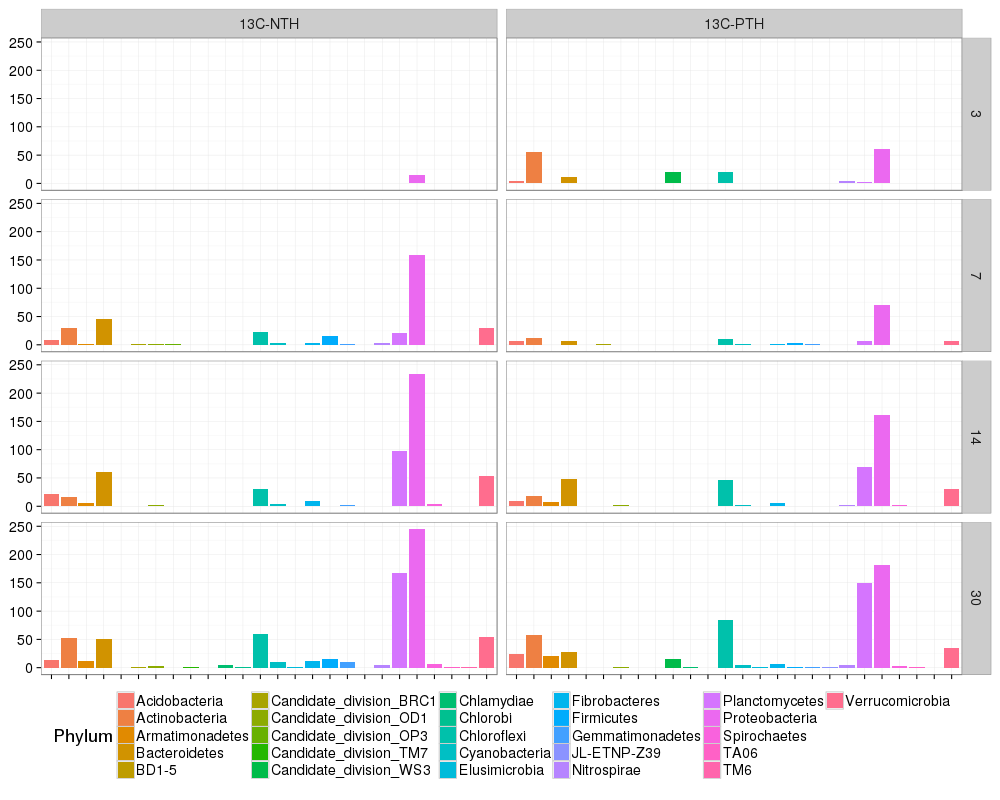

In [59]:
%%R -w 1000 -h 800
p.bar = ggplot(df.l2fc.f.f.sig, aes(Rank2)) +
geom_bar(stat = "count", na.rm = TRUE, aes(fill = Rank2)) + facet_grid(Day ~ ls, scale = "fixed") +
theme_bw(18) + theme(axis.text.x = element_blank())  + xlab(NULL) + ylab(NULL) + scale_fill_discrete(name = 'Phylum') + 
guides(fill = guide_legend(ncol=6)) + theme(legend.position = "bottom")

p.bar

In [60]:
%%R -i figDir
outFile = 'Resp_bar_lfc_Cell.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.bar, width=14, height=8)

In [61]:
%%R -i figDir
outFile = 'l2fc_sparCut0.3_byPhylumX.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.l2fc.x, width=12, height=4)

outFile = 'l2fc_sparCut0.3_byPhylumX2.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.l2fc.x, width=12, height=8)

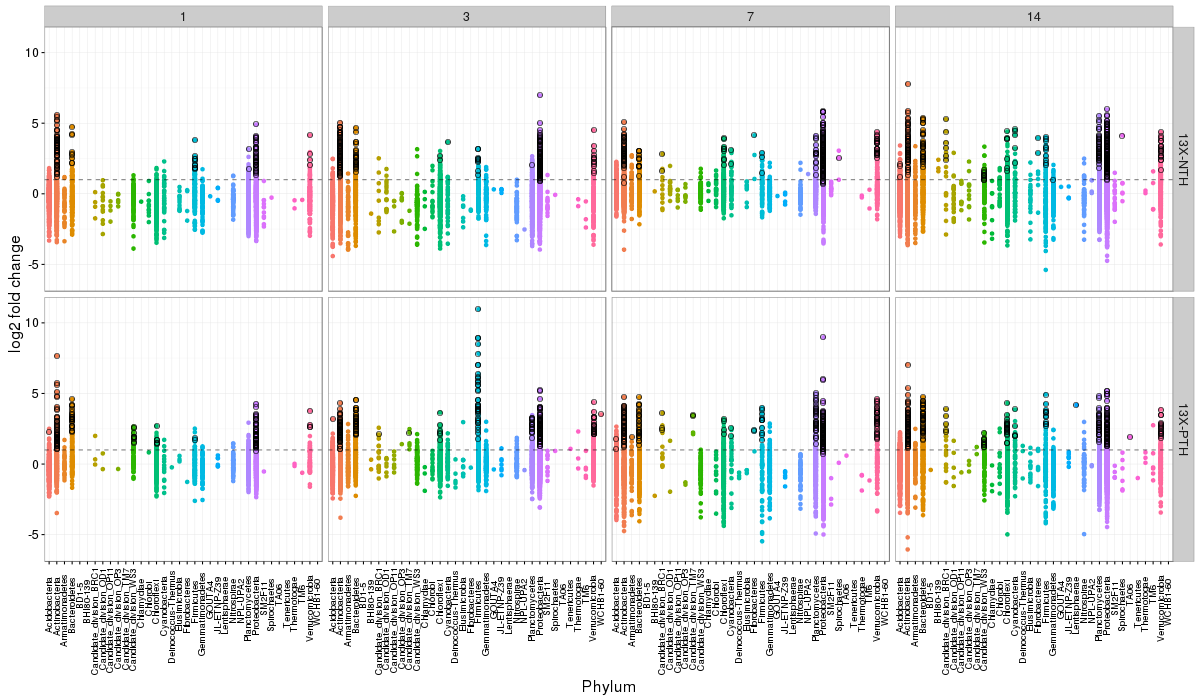

In [274]:
%%R -w 1200 -h 700
padj_cutoff = 0.10

df.l2fc.f.f = df.l2fc.f %>%
    filter(Substrate == '13X') %>%
    mutate(Rank2 = Rank2 %>% as.character)

df.l2fc.f.f = df.l2fc.f.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))
#df.l2fc.f.f$Phyl = reorder(df.l2fc.f.f$Rank2, -df.l2fc.f.f$log2FoldChange)


df.l2fc.f.f.sig = df.l2fc.f.f %>%
    filter(padj <= padj_cutoff) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))
#df.l2fc.f.f.sig$Phyl = reorder(df.l2fc.f.f.sig$Rank2, -df.l2fc.f.f.sig$log2FoldChange)

p.l2fc.x = ggplot(df.l2fc.f.f, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    geom_point(data=df.l2fc.f.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(ls~Day) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16), axis.text.x  = element_text(angle=90, vjust=0.4, hjust = 0.8, size=9)) +#,
        #axis.text.x = element_blank() 
         guides(color = FALSE)
p.l2fc.x

In [273]:
%%R -w 1500 -h 300

hist.xyl = df.l2fc.f.f %>% group_by(Day, ls, Rank2) %>% summarise(respcounts = sum(padj <=0.10))
hist.xyl[is.na(hist.xyl)] <- 0

head(hist.xyl)

Source: local data frame [6 x 4]
Groups: Day, ls [1]

    Day      ls                   Rank2 respcounts
  (int)   (chr)                   (chr)      (int)
1     1 13X-NTH           Acidobacteria          0
2     1 13X-NTH          Actinobacteria         61
3     1 13X-NTH         Armatimonadetes          0
4     1 13X-NTH           Bacteroidetes          9
5     1 13X-NTH Candidate_division_BRC1          0
6     1 13X-NTH  Candidate_division_OD1          0


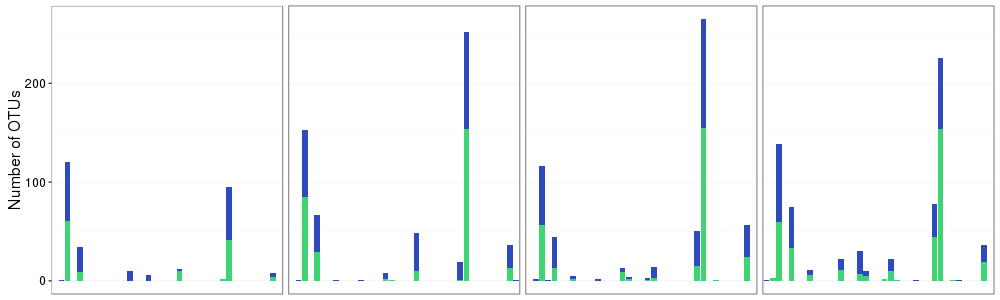

In [275]:
%%R -w 1000 -h 300
p.test = ggplot() + geom_bar(data = hist.xyl, aes(x = Rank2, y = respcounts, fill = ls), stat = 'identity',
                             position = 'stack') +
    facet_grid(1~Day) + theme_bw() + scale_fill_manual(name = 'Condition', values = c("#3ed474",
"#2e4bbd")) + theme(text = element_text(size = 16), axis.title.x = element_blank()) +
        ylab('Number of OTUs') +  scale_x_discrete(breaks=NULL)+ guides(fill = FALSE) + 
 theme(strip.background = element_blank(),
       strip.text.x = element_blank(), strip.text.y = element_blank()) 
p.test

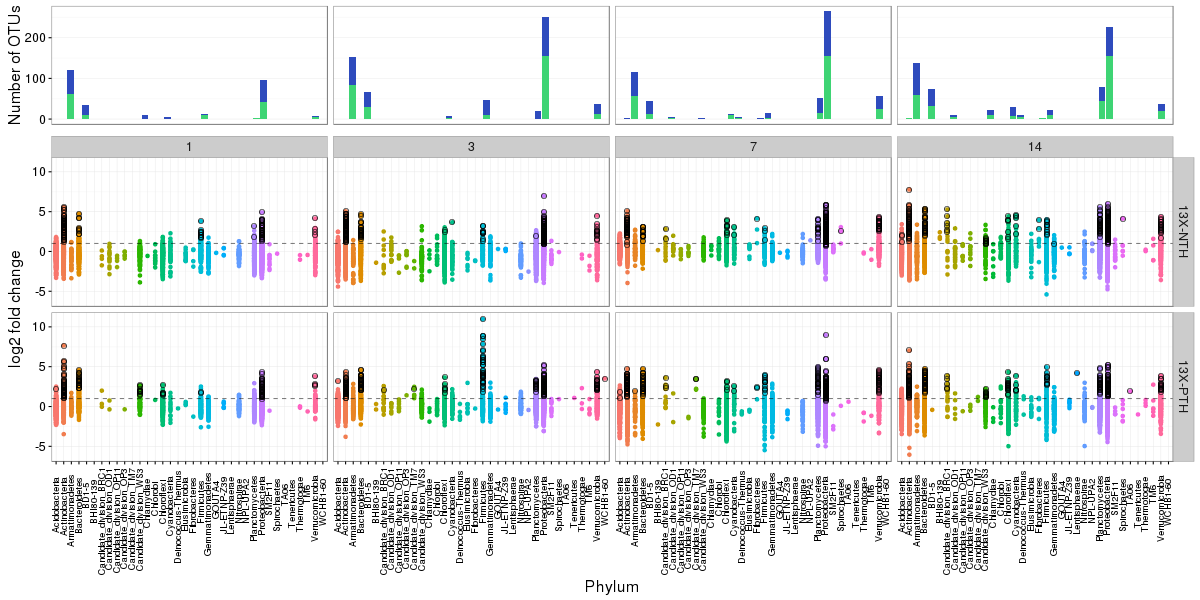

In [278]:
%%R -w 1200 -h 600
library(cowplot)

plot_grid(p.test, p.l2fc.x, nrow = 2, align = 'v', rel_heights = c(2.5, 9))


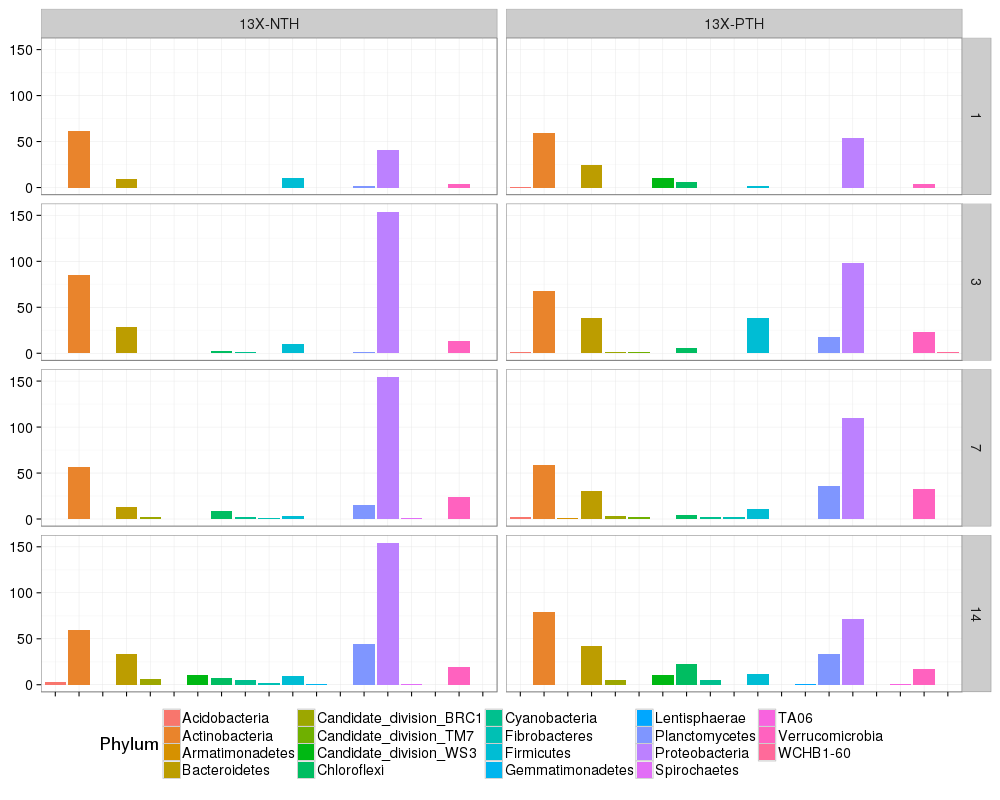

In [63]:
%%R -w 1000 -h 800
p.bar = ggplot(df.l2fc.f.f.sig, aes(Rank2)) +
geom_bar(stat = "count", na.rm = TRUE, aes(fill = Rank2)) + facet_grid(Day ~ ls, scale = "fixed") +
theme_bw(18) + theme(axis.text.x = element_blank())  + xlab(NULL) + ylab(NULL) + scale_fill_discrete(name = 'Phylum')+ 
guides(fill = guide_legend(ncol=6)) + theme(legend.position = "bottom")


p.bar

In [64]:
%%R -i figDir
outFile = 'Resp_bar_lfc_Xyl.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.bar, width=14, height=8)

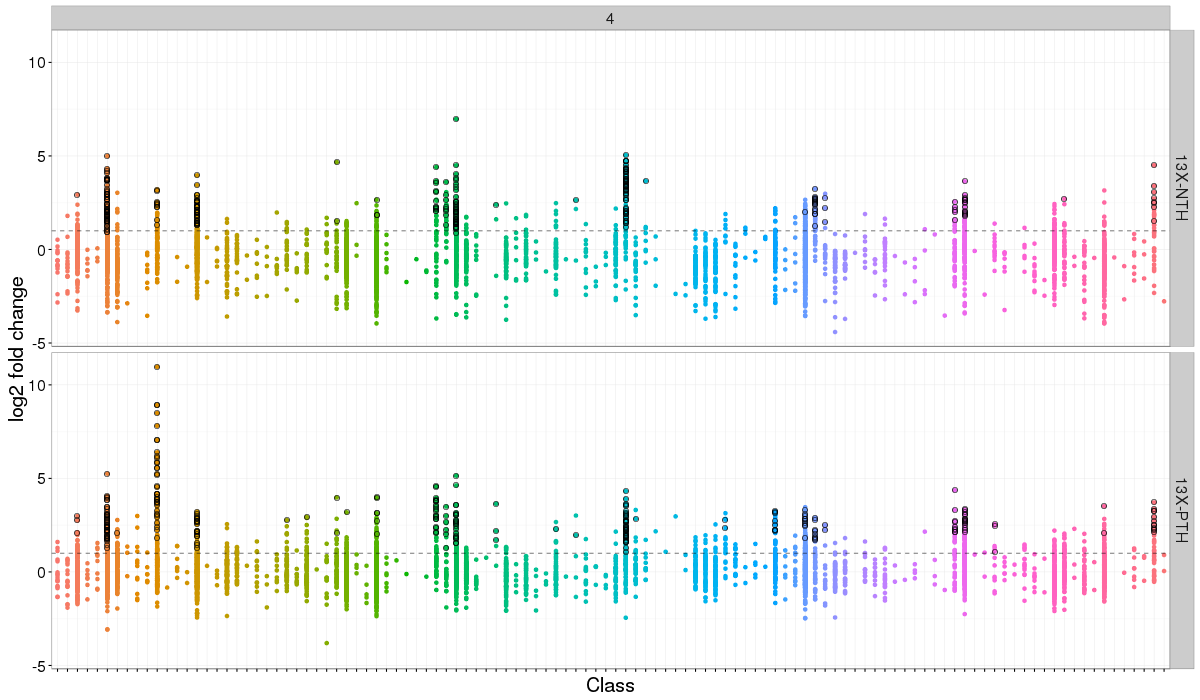

In [65]:
%%R -w 1200 -h 700
padj_cutoff = 0.10

df.l2fc.f.f = df.l2fc.f %>%
    filter(Substrate == '13X', Day == 3) %>%
    mutate(Rank3 = Rank3 %>% as.character)


df.l2fc.f.f = df.l2fc.f.f %>%
    mutate(Rank3 = gsub('^__', '', Rank3))

df.l2fc.f.f.sig = df.l2fc.f.f %>%
    filter(padj <= padj_cutoff) %>%
    mutate(Rank3 = gsub('^__', '', Rank3))

p.l2fc.x = ggplot(df.l2fc.f.f, aes(Rank3, color=Rank3)) +
    geom_point(aes(y=log2FoldChange)) +
    geom_point(data=df.l2fc.f.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(ls~Replicate) +
    scale_color_discrete('Class') +
    labs(x = 'Class', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=20),
        axis.text.x = element_blank() 
        )+ guides(fill = FALSE, color = FALSE)
p.l2fc.x 

In [66]:
%%R
filter(df.l2fc.f.f, Replicate != 2) %>% group_by(Substrate, Day, Land_Management, Replicate) %>% summarise(num = n())

Source: local data frame [2 x 5]
Groups: Substrate, Day, Land_Management [?]

  Substrate   Day Land_Management Replicate   num
     (fctr) (int)          (fctr)     (int) (int)
1       13X     3             NTH         4  4235
2       13X     3             PTH         4  5204


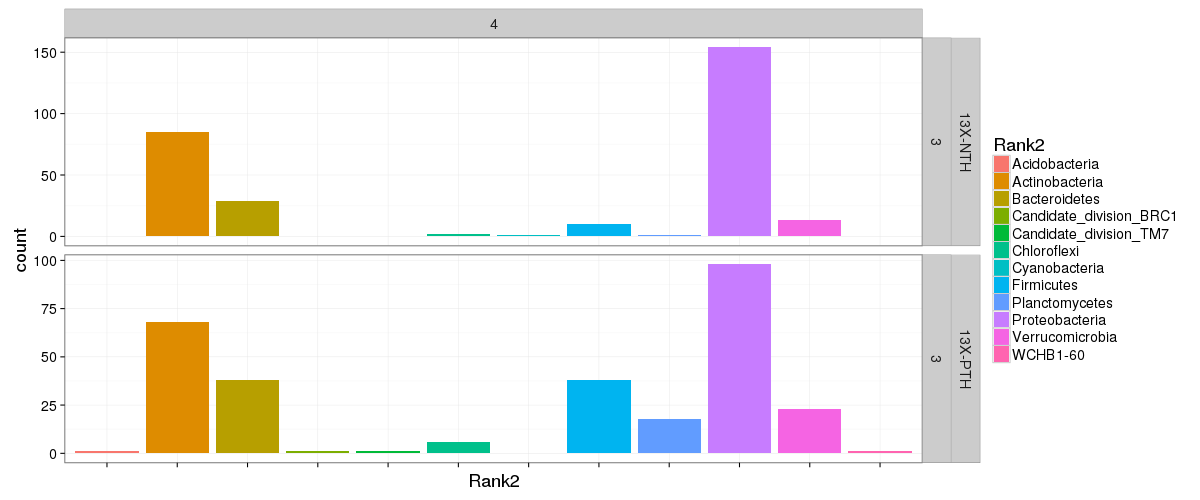

In [67]:
%%R -w 1200 -h 500
ggplot(df.l2fc.f.f.sig, aes(Rank2)) +
geom_bar(stat = "count", aes(fill = Rank2)) + facet_grid(Day~ls~Replicate, scale = "free_y") +
theme_bw(18) +  theme(axis.text.x = element_blank())

### Number of incorporators per treatment

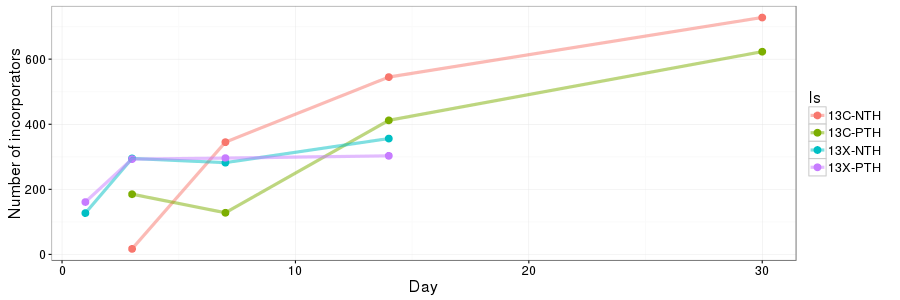

In [68]:
%%R -w 900 -h 300

padj_cutoff = 0.10

df.l2fc.f.sig = df.l2fc.f %>%
    group_by(ls, Day) %>%
    summarize(n = sum(padj <= padj_cutoff))

p.nInc = ggplot(df.l2fc.f.sig, aes(Day, n, color=ls, group=ls)) +
    geom_point(size=3) +
    geom_line(size=1.5, alpha=0.5) +
    labs(y='Number of incorporators') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )
p.nInc

In [69]:
%%R -i figDir
outFile = 'l2fc_sparCut0.3_nInc.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.nInc, width=10, height=3.5)

### Number of incorporators normalized by number of taxa in each sample

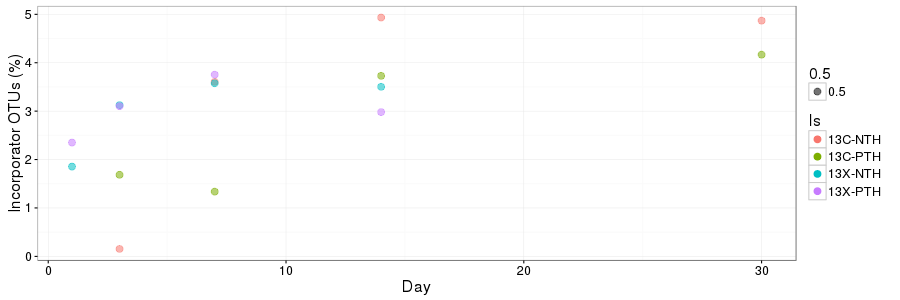

In [70]:
%%R -w 900 -h 300

padj_cutoff = 0.10

df.l2fc.f.sig = df.l2fc.f %>%
    group_by(Substrate, Day, Replicate) %>%
    mutate(ntaxa = n()) %>%
    group_by(ls, Day, ntaxa, Replicate) %>%
    summarize(n_incorp = sum(padj <= padj_cutoff)) %>%
    mutate(n_incorp_norm_perc = n_incorp / ntaxa * 100)

p.nInc.norm = ggplot(df.l2fc.f.sig, aes(Day, n_incorp_norm_perc, color= ls, group=ls,
                                         alpha = 0.5)) +
    geom_point(size= 3) +
    #geom_line(size=1.5, alpha=0.5) +
    labs(y='Incorporator OTUs (%)') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.y = element_text(vjust=1)
        )
p.nInc.norm

In [71]:
%%R -i figDir
outFile = 'l2fc_sparCut0.3_nIncNorm.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.nInc.norm, width=10, height=3.5)

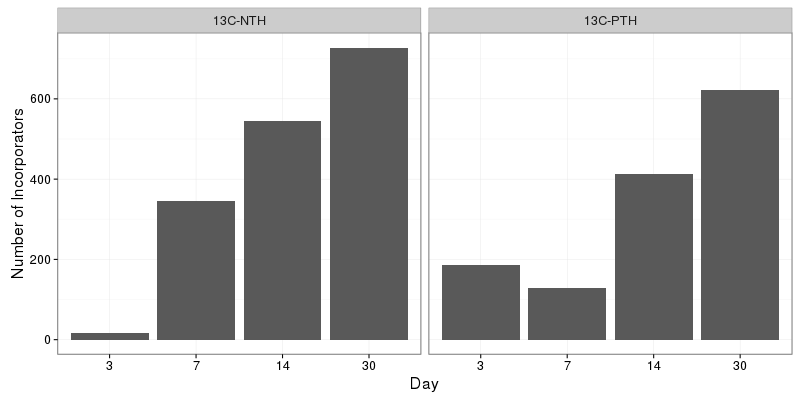

In [72]:
%%R -w 800 -h 400
Cel = filter(df.l2fc.f.sig, ls %in% c("13C-NTH", "13C-PTH"))
p = ggplot(Cel, aes(as.factor(Day), n_incorp))
p = p + geom_bar(stat = "identity")
p = p + facet_wrap(~ls, ncol = 2) + theme_bw(16) + labs(x = "Day", y = "Number of Incorporators")
p

In [73]:
%%R
ggsave(file ='data/figs/NumberIncorps_Time_Cellulose.jpg', p, width=8, height=4)

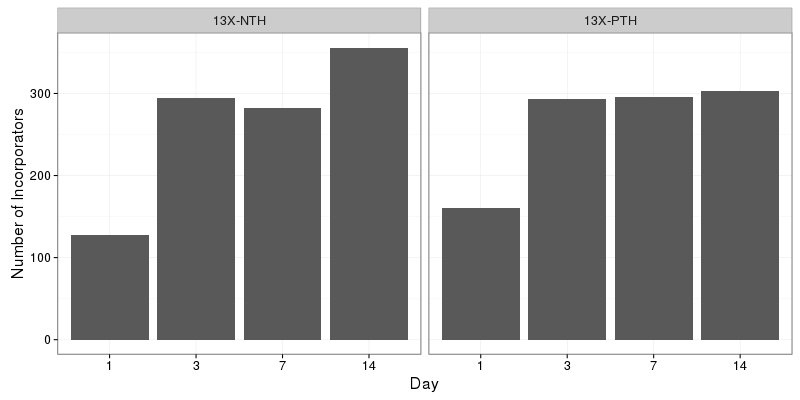

In [74]:
%%R -w 800 -h 400
Xyl = filter(df.l2fc.f.sig, ls %in% c("13X-NTH", "13X-PTH"), Replicate ==4)
p = ggplot(Xyl, aes(as.factor(Day), n_incorp))
p = p + geom_bar(stat = "identity")
p = p + facet_wrap(~ls, ncol = 2) + theme_bw(16) + labs(x = "Day", y = "Number of Incorporators")
p

In [75]:
%%R
ggsave(file ='data/figs/NumberIncorps_Time_Xylose.jpg', p, width=8, height=4)

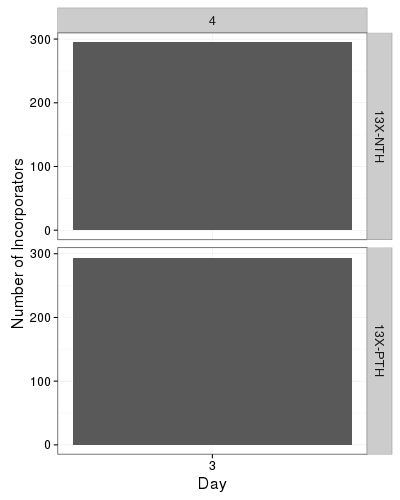

In [76]:
%%R -w 400 -h 500
Xyl2 = filter(df.l2fc.f.sig, ls %in% c("13X-NTH", "13X-PTH"), Day ==3)
p = ggplot(Xyl2, aes(as.factor(Day), n_incorp))
p = p + geom_bar(stat = "identity")
p = p + facet_grid(ls~Replicate) + theme_bw(16) + labs(x = "Day", y = "Number of Incorporators")
p

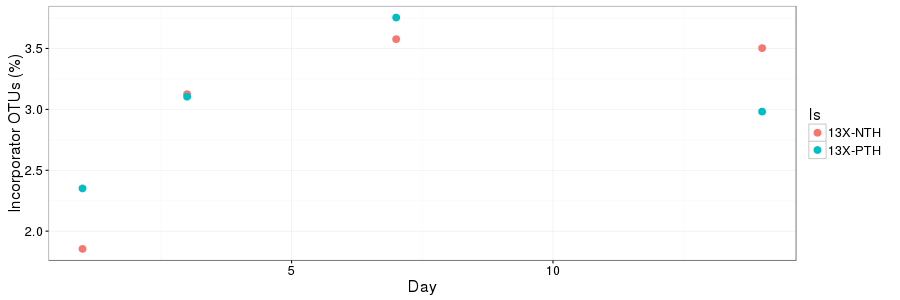

In [77]:
%%R -w 900 -h 300

padj_cutoff = 0.10

labile.sub = c("13X-NTH", "13X-PTH")

df.l2fc.f.sig.l = df.l2fc.f.sig %>%
    filter(ls %in% labile.sub)


p.nInc.norm.labile = ggplot(df.l2fc.f.sig.l, aes(Day, n_incorp_norm_perc, color=ls)) +
    geom_point(size=3) +
    #geom_line(size=1.5, alpha=0.5) +
    labs(y='Incorporator OTUs (%)') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.y = element_text(vjust=1) 
        ) 
p.nInc.norm.labile

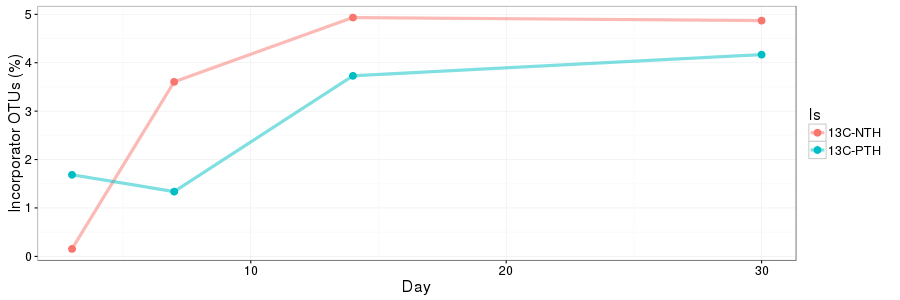

In [78]:
%%R -w 900 -h 300

padj_cutoff = 0.10

recal.sub = c("13C-NTH", "13C-PTH")

df.l2fc.f.sig.l = df.l2fc.f.sig %>%
    filter(ls %in% recal.sub)


p.nInc.norm.recal = ggplot(df.l2fc.f.sig.l, aes(Day, n_incorp_norm_perc, color=ls, group=ls)) +
    geom_point(size=3) +
    geom_line(size=1.5, alpha=0.5) +
    labs(y='Incorporator OTUs (%)') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.y = element_text(vjust=1)
        )
p.nInc.norm.recal

In [79]:
%%R -i figDir
outFile = 'l2fc_sparCut0.3_nIncNorm-labile.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.nInc.norm.labile, width=10, height=3.5)

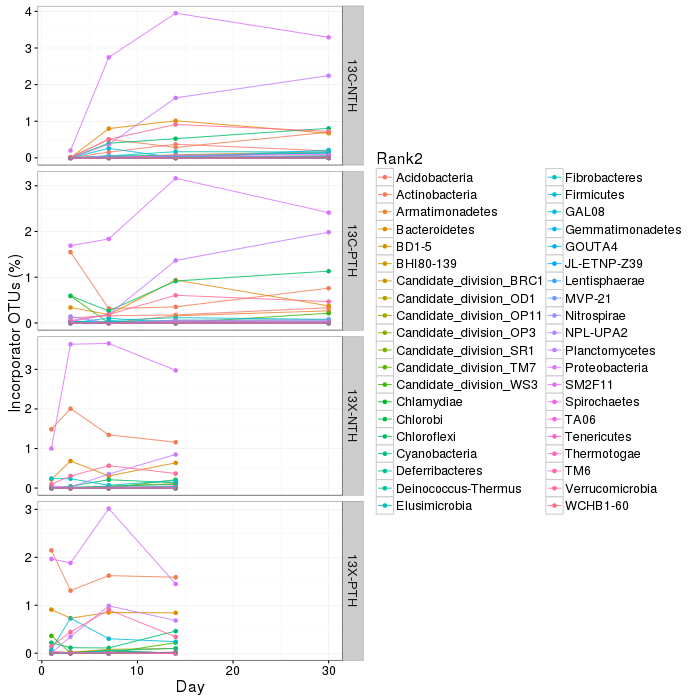

In [80]:
%%R -w 700 -h 700

padj_cutoff = 0.10

df.l2fc.f.sig = df.l2fc.f %>%
    group_by(ls, Day) %>%
    mutate(ntaxa = n()) %>%
    group_by(ls, Day, Rank2, ntaxa) %>%
    summarize(n_incorp = sum(padj <= padj_cutoff)) %>%
    mutate(n_incorp_norm_perc = n_incorp / ntaxa * 100) %>%
    ungroup %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

ggplot(df.l2fc.f.sig, aes(Day, n_incorp_norm_perc, color=Rank2, group=Rank2)) +
    geom_point() +
    geom_line(alpha=0.8) +
    facet_grid(ls ~ ., scales='free_y') +
    labs(y='Incorporator OTUs (%)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

In [81]:
%%R
head(tmp)


Error in head(tmp) : object 'tmp' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in head(tmp) : object 'tmp' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: There were 15 warnings (use warnings() to see them)
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [82]:
%%R
range(tmp$n_incorp)


Error in withVisible({ : object 'tmp' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in withVisible({ : object 'tmp' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


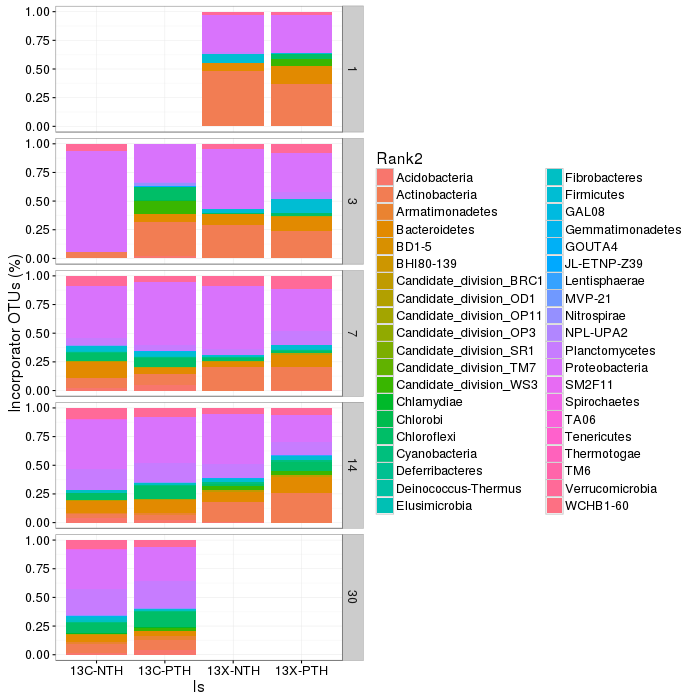

In [83]:
%%R -w 700 -h 700

tmp = df.l2fc.f.sig %>%
    mutate(Day = Day %>% as.character)

tmp$Day = reorder(tmp$Day, tmp$Day %>% as.numeric)

ggplot(tmp, aes(ls, n_incorp, fill=Rank2, group=Rank2)) +
    geom_bar(stat='identity', position='fill') +
    facet_grid(Day ~ ., scales='free_y') +
    labs(y='Incorporator OTUs (%)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

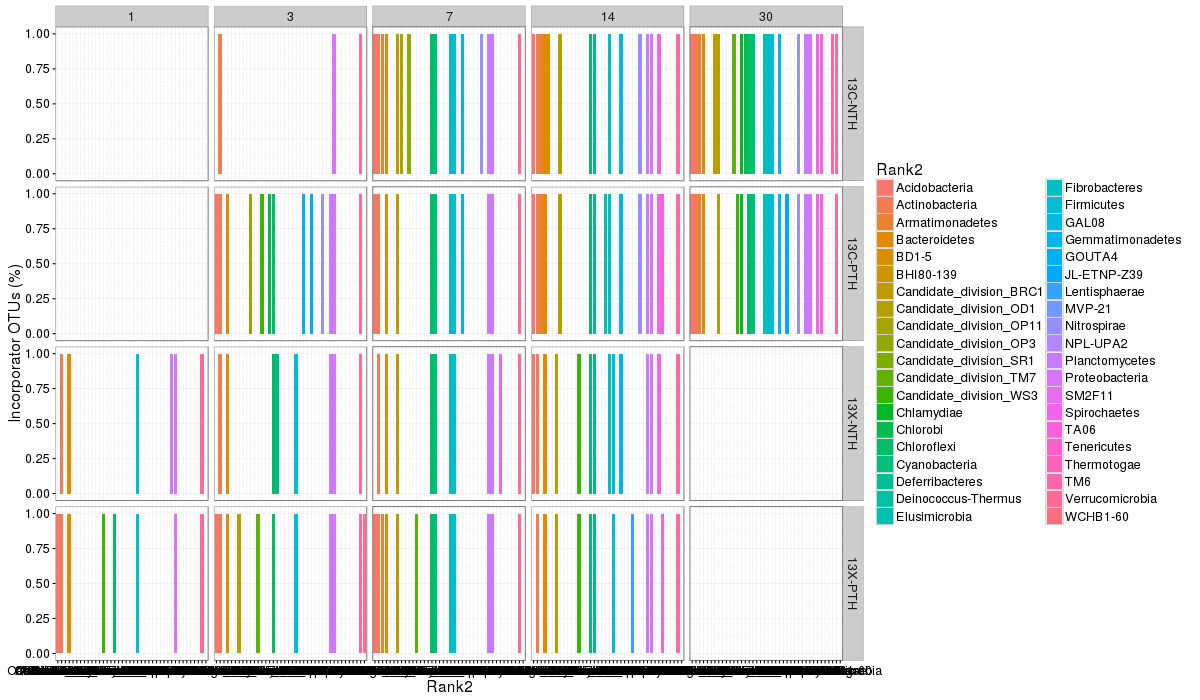

In [84]:
%%R -w 1200 -h 700

tmp = df.l2fc.f.sig %>%
    mutate(Day = Day %>% as.character)

tmp$Day = reorder(tmp$Day, tmp$Day %>% as.numeric)

ggplot(tmp, aes(Rank2, n_incorp_norm_perc, fill=Rank2, group=Rank2)) +
    geom_bar(stat='identity', position='fill') +
    facet_grid(ls ~ Day, scales='free_y') +
    labs(y='Incorporator OTUs (%)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )